In [1]:
!nvidia-smi

Wed Apr 14 20:34:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

/bin/bash: Install: command not found
Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 213 (delta 22), reused 3 (delta 0), pack-reused 171
Receiving objects: 100% (213/213), 64.29 KiB | 12.86 MiB/s, done.
Resolving deltas: 100% (84/84), done.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT SCRIPT CHANGES: Colab has updated to Python 3.7, and now runs our STABLE and NIGHTLY versions (0.18 and 0.19)!  PLEASE update your older install script code as follows:
	!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18

	import sys, os

	dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
	sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
	sys.path
	exec(open('rapidsai-csp-utils/col

In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [101]:
import cudf
df = cudf.read_csv('//content/drive/MyDrive/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [102]:
df = df.drop( ['Time'], axis=1 )
df = df.astype('float32') # float çevirmezsek .values metodu için String Arrays is not yet implemented in cudf hatasi aliyoruz.
y = df['Class'].values
X = df.drop( ['Class'], axis=1 )

In [103]:
import cuml
from cuml.manifold import TSNE

In [104]:
%%time
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X)

[W] [22:38:24.557413] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 8.9 s, sys: 9.73 s, total: 18.6 s
Wall time: 18.6 s


In [105]:
import cupy as cp

y_np = y.get() # .get() : cupy array --> numpy array for matplotlib execute

plot_x = tsne_data[tsne_data.columns[0]]
plot_x = cp.asarray(plot_x).get() #cupy series --> cupy array --> numpy array for matplotlib execute
plot_y = tsne_data[tsne_data.columns[1]]
plot_y = cp.asarray(plot_y).get() #cupy series --> cupy array --> numpy array for matplotlib execute

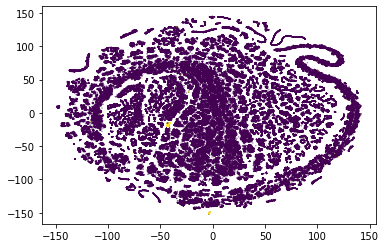

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(plot_x, plot_y, c = y_np, s = 0.05)

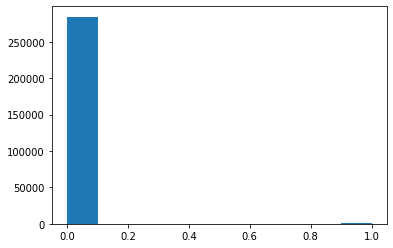

In [107]:
plt.hist(y_np)
plt.show()
# highly imbalanced durumu olduğu için yukarida Class:1 ler farkedilemiyor.

In [108]:
type(y) , type(X)

(cupy.core.core.ndarray, cudf.core.dataframe.DataFrame)

In [109]:
#premium olmayan colab kullanimi gereği bazi noktalarda disk yeterli olmayabilir. 
#disk 55/68 gb kullaniyor, colabte rapids.ai kurulunca en baştan disk şişiyor.
#localde kurmak içinse windows uygun değil .. 
#bazı durumların çözümü için multigpu Dask-cuDF kullanabiliriz. (parallel execute)

#örnek olarak;
import dask_cudf
dask_X = dask_cudf.from_cudf(X, npartitions=2)
dask_y = dask_cudf.from_cudf(cudf.DataFrame(y), npartitions=2)
#dask_cudf.concat([dask_X_, dask_y],axis=1, ).compute()
dask_X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
npartitions=2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
142404,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284806,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [110]:
from cuml.manifold.umap import UMAP as cuUMAP
from sklearn.manifold import trustworthiness

In [111]:
trained_UMAP = cuUMAP( n_neighbors = 10 ).fit( X )
X_embedded = trained_UMAP.transform( X )

cu_score = cuml.metrics.trustworthiness( X, X_embedded )

print("cuml's trustworthiness score: ", cu_score) 

/usr/local/lib/python3.7/site-packages/cuml/internals/api_decorators.py:361: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 
  return func(*args, **kwargs)


cuml's trustworthiness score:  0.9756204657686234


In [112]:
from cuml import PCA
from cuml.decomposition import PCA

In [119]:
pca = PCA(n_components = 5)
pca.fit_transform(X)

,0,1,2,3,4
0,61.271397,1.319366,-1.293700,-2.370544,1.137322
1,-85.661812,-1.043777,0.112475,-0.246804,0.443755
2,290.316711,0.810817,-1.362608,-1.740054,0.077547
3,35.151676,0.928375,-1.106099,-1.399498,-0.971079
4,-18.360266,1.317285,-0.139529,-1.775381,0.188883
...,...,...,...,...,...
284802,-87.586266,13.128977,12.146799,4.245009,-2.710937
284803,-63.560566,0.876701,-1.487659,-1.158149,-0.651566
284804,-20.470726,-1.970734,1.356302,3.306361,0.020999
284805,-78.350624,0.408139,-0.002161,-0.882166,0.547252


In [120]:
pca.explained_variance_ratio_

0    0.999538
1    0.000060
2    0.000039
3    0.000035
4    0.000032
dtype: float32

In [115]:
from cuml import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, 'Class',
                                                    train_size=0.8)

In [116]:
from cuml.ensemble import RandomForestClassifier as cuRF
from sklearn.metrics import accuracy_score

In [117]:
model = cuRF( max_depth = 10, 
              n_estimators = 25,
              seed  = 0 )

trained_RF = model.fit ( X_train, y_train )

predictions = model.predict ( X_test )

cu_score = cuml.metrics.accuracy_score( y_test, predictions )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Parameter 'seed' is deprecated and will be removed in 0.17. Please use 'random_state' instead. Setting 'random_state' as the curent 'seed' value
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams==1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  This is separate from the ipykernel package so we can avoid doing imports until


In [118]:
cu_score

0.9994382262229919

In [125]:
# dfler yukarida ornegi olan sekilde dask_cudf ye çevirilip Rapids-dask kullanılarak; cuml.dask.ensemble.RandomForestClassifier şeklinde rf modeli de kullanilabilir
# multi gpu based cuml algorithm ..